In [84]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.utils.data
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transfroms 
import os
import torchvision
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
from tqdm import tqdm
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from torchvision import models
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

torch.manual_seed(2002)

In [65]:
def weights_init(net, std=0.02):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, std)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, std)
        nn.init.constant_(net.bias.data, 0.0)


class Generator(nn.Module): #
    def __init__(self, nc=3, dim_z=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(dim_z, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(ngf, nc, 1, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [66]:
class Probability(nn.Module):
    def __init__(self, D):
        super(Probability, self).__init__()
        self.D = D

    def forward(self, x):
        prob = self.D(x)
        return prob

    def ar(self, x_s, x_p):
        d_s = self.D(x_s).cpu()
        d_p = self.D(x_p).cpu()
        log_prob = tlog(1. - d_s) + tlog(d_p) - tlog(d_s) - tlog(1 - d_p)
        log_prob = torch.clamp(log_prob, max=0.0).view(log_prob.size(0), )
        return torch.exp(log_prob)

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
def train(D, G, dataloader, lr, epoch_n, device, verbose, ml_ls, path_f='.'):
    read_names = []
    loss_history = []
    ar_history = []
    dim_z = 100
    real_label = 1
    fake_label = 0
    D.to(device)
    G.to(device).eval()

    optimizer = optim.Adam(D.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=ml_ls, gamma=0.1)
    criterion = nn.BCELoss()
    count_object = 0
    z=torch.zeros(100,100, 1, 1, device=device)
    z=z.to(device)
    pi3=torch.Tensor([3.141592635/3])
    pi3=pi3.to(device)
    print('Start')
    for epoch in range(epoch_n):
        for i, data in (enumerate(dataloader, 0)):
            x_s = data[0].to(device)
            b_size = x_s.size(0)
            count_object += b_size

            with torch.no_grad():

                noise = torch.randn(b_size, dim_z, 1, 1, device=device)
                z=torch.cos(pi3)*z+torch.sin(pi3)*noise
                x_p = G(z)
                batch = torch.cat([x_s, x_p])
                l_s = torch.full((b_size, ), real_label, device=device)
                l_p = torch.full((b_size, ), fake_label, device=device)

            fake_output = D(x_p.detach()).view(-1)
            real_output = D(x_s.detach()).view(-1)
            real_loss = criterion(real_output.to(torch.float32), l_s.to(torch.float32))
            fake_loss = criterion(fake_output.to(torch.float32), l_p.to(torch.float32))
            loss = real_loss + fake_loss

            loss_history.append([count_object, loss.item()])

            optimizer.zero_grad()
            real_loss.backward()
            fake_loss.backward()

            optimizer.step()
            scheduler.step()

            if i % verbose == 0:
                with torch.no_grad():
                    fake_score = torch.mean(D(x_p)).item()
                    true_score = torch.mean(D(x_s)).item()
                    ar = torch.mean(D.ar(x_s, x_p)).item()
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tFake score: %4f\tReal score: %4f, AR: %4f'
                      % (epoch, epoch_n-1, i, len(dataloader), loss.item(), fake_score, true_score, ar))
                D.to(device)
    torch.cuda.empty_cache()
    print(path_f)
    return 0

In [70]:


class InceptionV3(nn.Module): #https://github.com/tamarott/SinGAN/blob/master/SIFID/inception.py
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        32: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradient. Possibly useful
            for finetuning the network
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


In [131]:



def get_dataloader(dataset, dataroot, image_size, batch_size, workers):
  dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
  dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=workers)

  return dataloader


lr_m = '10,20'
lr_decay = [int(item) for item in lr_m.split(',')]


def weights_init(net, std=0.02):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, std)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, std)
        nn.init.constant_(net.bias.data, 0)

def G_D():
    G = Generator()
    G.load_state_dict(torch.load('/content/gdrive/MyDrive/trainingcheckpoints/dcgan/weights/netG_epoch_199.pth', map_location='cpu'))
#     G = model.getNetG()
    G.eval()
    D = Discriminator()
    D.apply(weights_init)
    W = Probability(D)

    return G, W
device = 'cuda'
gan = 'DCGAN'
dataloader = get_dataloader(dataset='cifar', dataroot='./data',
                            image_size=32,
                            batch_size=100,
                            workers=1)

device = torch.device(device)
G, W = G_D()
epoch_n = 30
verbose = 50
lr = 2e-4
dataset = 'cifar'
path_f = '/content/gdrive/MyDrive/trainingcheckpoints/dcgan/'


train(D=W, G=G, dataloader=dataloader,
          lr=lr, epoch_n=epoch_n, device=device,
          verbose=verbose, ml_ls=lr_decay, path_f=path_f)




Files already downloaded and verified
Start
[0/29][0/500]	Loss_D: 1.4391	Fake score: 0.227559	Real score: 0.438968, AR: 0.445722
[0/29][50/500]	Loss_D: 1.2445	Fake score: 0.426605	Real score: 0.541811, AR: 0.632197
[0/29][100/500]	Loss_D: 1.2873	Fake score: 0.430676	Real score: 0.530768, AR: 0.649797
[0/29][150/500]	Loss_D: 1.0628	Fake score: 0.399398	Real score: 0.605775, AR: 0.502533
[0/29][200/500]	Loss_D: 1.1533	Fake score: 0.425423	Real score: 0.583309, AR: 0.552973
[0/29][250/500]	Loss_D: 1.0953	Fake score: 0.414562	Real score: 0.600881, AR: 0.503963
[0/29][300/500]	Loss_D: 1.0063	Fake score: 0.383787	Real score: 0.621637, AR: 0.424404
[0/29][350/500]	Loss_D: 1.0554	Fake score: 0.392939	Real score: 0.600217, AR: 0.483845
[0/29][400/500]	Loss_D: 1.0802	Fake score: 0.414574	Real score: 0.613120, AR: 0.491825
[0/29][450/500]	Loss_D: 1.0380	Fake score: 0.372512	Real score: 0.600835, AR: 0.457201
[1/29][0/500]	Loss_D: 0.8927	Fake score: 0.339027	Real score: 0.645995, AR: 0.325226
[1/2

0

In [132]:
import torch
from torch import log as tlog
import numpy as np


class ZSampler:
    def __init__(self, dim, device):
        self.dim = dim
        self.device = device

    def sample(self, K):
        return torch.randn(K, self.dim, 1, 1, device=self.device)


class NoFilter:
    def __init__(self, device, G, sampler, img_dims=(3, 32, 32)):
        self.device = device
        self.G = G.eval().to(device)  # self.G = G.eval().to(device)
        self.sampler = sampler
        self.img_dims = img_dims
        self.chain = None

    def transition_step(self, K):
        with torch.no_grad():
            z = self.sampler.sample(K).to(self.device)
            x_p = self.G(z.detach()).cpu().data
            return x_p

    def sample_chain(self, N, K):
        n_batches = N // K
        n_chain = K * n_batches
        chain = torch.empty((n_chain, *self.img_dims))
        for i in range(n_batches):
            start_pointer = i * K
            end_pointer = i * K + K
            chain[start_pointer:end_pointer] = self.transition_step(K)
        self.chain = chain
        return 0


class ImhFilter:
    def __init__(self, device, D, G, sampler, img_dims=(3, 32, 32)):
        self.device = device
        self.D = D.eval().to(device)
        self.G = G.eval().to(device)
        self.sampler = sampler
        self.img_dims = img_dims
        self.chain = None
        self.state = None
        self.e_ar = None

    def log_prob(self, x_s, x_p):
        with torch.no_grad():
            d_s = self.D(x_s).cpu()
            d_p = self.D(x_p).cpu()
            log_prob = tlog(1.-d_s) + tlog(d_p) - tlog(d_s) - tlog(1-d_p)
            log_prob = torch.clamp(log_prob, max=0.0).view(log_prob.size(0),)
        return log_prob

    def multiple_chain_step(self, x_s):
        with torch.no_grad():
            K = x_s.size(0)
            z = self.sampler.sample(K).to(self.device)
            x_p = self.G(z.detach())
            log_ar = self.log_prob(x_s, x_p)
            u = torch.rand(K)
            flag_acc = (log_ar > tlog(u))
        return x_p, flag_acc

    def sample_chains(self, N, init):
        with torch.no_grad():
            self.state = init.clone()
        K = init.size(0)
        n_batches = N // K
        n_chain = K * n_batches
        chain = torch.empty((n_chain, *self.img_dims))
        
        for i in range(n_batches):
            start_pointer = i * K
            end_pointer = i * K + K
            x_s = self.state.to(self.device)
            x_p, flag = self.multiple_chain_step(x_s)
            self.state[flag].data = x_p.cpu().data[flag]
            chain[start_pointer:end_pointer] = self.state.data
        self.chain = chain
        return 0

    def sample_chains_only_accepts(self, N, init):
        self.chain = []
        with torch.no_grad():
            self.state = init.clone()
        i = 0
        while i < N:
            x_s = self.state.to(self.device)
            x_p, flag_acc = self.multiple_chain_step(x_s)
            n_accept = torch.sum(flag_acc).item()
            if n_accept > 0:
                self.chain.append(x_p[flag_acc].cpu().data)
                self.state.data[flag_acc] = x_p.cpu().data[flag_acc]
                i += n_accept
        return 0

    def sample_chains_reinit(self, N, K, init):
        self.chain = []
        with torch.no_grad():
            self.state = init.clone()
        i = 0
        k = 0
        while i < N:
            x_s = self.state.to(self.device)
            x_p, flag_acc = self.multiple_chain_step(x_s)
            n_accept = torch.sum(flag_acc).item()
            if n_accept > 0:
                self.chain.append(x_p[flag_acc].cpu().data)
                self.state.data[flag_acc] = x_p.cpu().data[flag_acc]
                i += n_accept
                k += n_accept
            if k > K:
                k = 0
                with torch.no_grad():
                    self.state = init.clone()
        return 0


In [142]:
def inception_score(imgs, device, batch_size=32, resize=False, splits=1): #https://github.com/1Konny/idgan/blob/master/gan_training/metrics/inception_score.py
    """
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    """

    N = len(imgs)
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').to(device)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    preds = np.zeros((N, 1000))
    for i, batch in enumerate(dataloader, 0):
        sample = batch[0].to(device)
        batch_size_i = sample.size(0)

        preds[i * batch_size:i * batch_size + batch_size_i] = get_pred(sample)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    return split_scores



In [134]:
def get_activations(dataloader, model, device, verbose=False):
    """
        :param dataloader: (n_images, 3, height, width) from -1 to 1
        :param model: inception model
        :param device: cpu or indexed cuda
        :return:
    """
    dims = 2048
    model.eval()
    n_imgs = len(dataloader.dataset)
    n_batches = len(dataloader)

    pred_arr = np.empty((n_imgs, dims))
    start_pointer = 0

    for i, batch in enumerate(dataloader, 0):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches), flush=True)
        sample = batch[0].to(device)
        batch_size_i = sample.size(0)
        end_pointer = start_pointer + batch_size_i

        pred = model(sample)[0]
        pred_arr[start_pointer:end_pointer] = pred.cpu().data.numpy().reshape(batch_size_i, -1)
        start_pointer += batch_size_i

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6, full=False):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    if full:
        # Product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real
        tr_covmean = np.trace(covmean)
    else:
        print('diag approx')
        sigma1_diag = np.diag(sigma1)
        sigma2_diag = np.diag(sigma2)
        covmean = np.sqrt(sigma1_diag * sigma2_diag)
        tr_covmean = np.sum(covmean)

    fid_mu = diff.dot(diff)
    fid_cov = np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    fid = fid_mu + fid_cov

    return fid, fid_mu, fid_cov


def calculate_activation_statistics(dataloader, model, device):
    act = get_activations(dataloader, model, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma


def load_statistics_of_path(path):
    m, s = None, None
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()

    return m, s


def calculate_fid(dataloaders, device, full=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx], normalize_input=False)
    model.to(device)

    m1, s1 = calculate_activation_statistics(dataloaders[0], model, device)
    m2, s2 = calculate_activation_statistics(dataloaders[1], model, device)

    fid_value = calculate_frechet_distance(m1, s1, m2, s2, full=full)

    return fid_value


In [135]:
def original_gen_scores(G, dim_z, init, device, true_activation_path,
                        chain_size=int(10e3), full=True):
    z = ZSampler(dim_z, device)
    sampler = NoFilter(device, G, z)
    sampler.sample_chain(chain_size, init.size(0))
    dataset_g = torch.utils.data.TensorDataset(sampler.chain)
    assert len(dataset_g) >= chain_size - init.size(0)
    is_g = inception_score(dataset_g, device, resize=True, splits=1)[0]
    torch.cuda.empty_cache()

    dataloader_g = torch.utils.data.DataLoader(dataset_g, batch_size=256, shuffle=True, num_workers=40)
    fid_g = calculate_fid([true_activation_path, ''], [dataloader, dataloader_g], device, full=full)
    torch.cuda.empty_cache()
    print(is_g, fid_g)
    return is_g, fid_g


def imh_scores(D, G, dim_z, init, device, true_activation_path,
                          chain_size=int(10e3), full=True):
    print('Start sampling')
    z = ZSampler(dim_z, device)
    sampler = ImhFilter(device, D, G, z)
    sampler.sample_chains_only_accepts(chain_size, init)
    n_acc = [i.size(0) for i in sampler.chain]
    print('Avg. accep per batch:', np.mean(np.array(n_acc) / init.size(0)))

    chain = torch.cat(sampler.chain)
    dataset_mh = torch.utils.data.TensorDataset(chain)
    assert len(dataset_mh) >= chain_size

    is_mh = inception_score(dataset_mh, device, resize=True, splits=1)[0]
    torch.cuda.empty_cache()

    dataloader_mh = torch.utils.data.DataLoader(dataset_mh, batch_size=256, shuffle=True, num_workers=40)
    fid_mh = calculate_fid([true_activation_path, ''], [dataloader, dataloader_mh], device, full=full)
    torch.cuda.empty_cache()

    print(is_mh, fid_mh)
    return is_mh, fid_mh


In [136]:
def get_activations(dataloader, model, device, verbose=False): #https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py
    """
        :param dataloader: (n_images, 3, height, width) from -1 to 1
        :param model: inception model
        :param device: cpu or indexed cuda
        :return:
    """
    dims = 2048
    model.eval()
    n_imgs = len(dataloader.dataset)
    n_batches = len(dataloader)

    pred_arr = np.empty((n_imgs, dims))
    start_pointer = 0

    for i, batch in enumerate(dataloader, 0):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches), flush=True)
        sample = batch[0].to(device)
        batch_size_i = sample.size(0)
        end_pointer = start_pointer + batch_size_i

        pred = model(sample)[0]
        pred_arr[start_pointer:end_pointer] = pred.cpu().data.numpy().reshape(batch_size_i, -1)
        start_pointer += batch_size_i

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6, full=False):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    if full:
        # Product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real
        tr_covmean = np.trace(covmean)
    else:
        print('diag approx')
        sigma1_diag = np.diag(sigma1)
        sigma2_diag = np.diag(sigma2)
        covmean = np.sqrt(sigma1_diag * sigma2_diag)
        tr_covmean = np.sum(covmean)

    fid_mu = diff.dot(diff)
    fid_cov = np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    fid = fid_mu + fid_cov

    return fid, fid_mu, fid_cov


def calculate_activation_statistics(dataloader, model, device):
    act = get_activations(dataloader, model, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma


def load_statistics_of_path(path):
    m, s = None, None
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()

    return m, s


def calculate_fid(paths, dataloaders, device, full=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx], normalize_input=False)
    model.to(device)

    if paths[0].endswith('.npz'):
        m1, s1 = load_statistics_of_path(paths[0])
    else:
        m1, s1 = calculate_activation_statistics(dataloaders[0], model, device)

    if paths[1].endswith('.npz'):
        m2, s2 = load_statistics_of_path(paths[1])
    else:
        m2, s2 = calculate_activation_statistics(dataloaders[1], model, device)

    print(full)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2, full=full)

    np.savez('path0_act.npz', mu=m1, sigma=s1)
    np.savez('path1_act.npz', mu=m2, sigma=s2)

    return fid_value

In [138]:
def initialize(dataset,dataroot, image_size, batch_size):
  dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))

  dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=1)

  return next(iter(dataloader))[0]


In [139]:
init = initialize(dataset='cifar',dataroot='/content/gdrive/MyDrive/trainingcheckpoints/dcgan/data',image_size=(32,32), batch_size=128)

Files already downloaded and verified


In [140]:
score_g = []
for i in range(5):
    is_g, fid_g = original_gen_scores(G, 100, init, device,
                                      '.', chain_size=10000)
    score_g.append((is_g, fid_g))


score_mh = []
for i in range(5):
    is_mh, fid_mh = imh_scores(W, G, 100, init, device,
                                          '.', chain_size=10000)
    score_mh.append((is_mh, fid_mh))



True
4.7665414025379125 (32.16055873598535, 11.09894410083567, 21.06161463514968)
True
4.762169048521169 (32.329681135525114, 11.212466422032726, 21.117214713492388)
True
4.834736085729466 (32.02359508350092, 11.038444133296409, 20.985150950204513)
True
4.779713617989421 (32.16146191854958, 11.054752779077004, 21.10670913947257)
True
4.819395644996919 (32.30768729322444, 11.155905111137777, 21.151782182086663)
Start sampling
Avg. accep per batch: 0.37839673913043476
True
4.8799203036711045 (32.06312059323197, 11.16530887636911, 20.89781171686286)
Start sampling
Avg. accep per batch: 0.3624855324074074
True
4.859089773757563 (32.079787176783206, 11.143283908140399, 20.93650326864281)
Start sampling
Avg. accep per batch: 0.3617259837962963
True
4.844446749464754 (32.5365989915329, 11.263722029899082, 21.272876961633813)
Start sampling
Avg. accep per batch: 0.3719638625592417
True
4.810165496267019 (32.252838170543825, 11.183516408567055, 21.069321761976767)
Start sampling
Avg. accep per 

In [141]:
obj_save = (score_g, score_mh, 30)
path_save = '%s/_score_g_%s' % (path_f+'is_fid_m', '30')
torch.save(obj=obj_save, f=path_save)

In [143]:
g_is_fid=[]
imh_is_fid=[]
for s in ['5','10','15','20','25','30']:
  arr=torch.load('%s/_score_g_%s' % (path_f+'is_fid_m', s))
  g_is_fid.append(arr[0])
  imh_is_fid.append(arr[1])
  

In [144]:
g_is=[]
g_is_scat=[]
imh_is=[]
imh_is_scat=[]
g_fid=[]
g_fid_scat=[]
imh_fid=[]
imh_fid_scat=[]
for i in range(6):
  for j in range(5):
    g_is_scat.append(g_is_fid[i][j][0])
    g_fid_scat.append(np.mean(g_is_fid[i][j][1]))
    imh_is_scat.append(imh_is_fid[i][j][0])
    imh_fid_scat.append(np.mean(imh_is_fid[i][j][1]))
  g_is_scat=tuple(g_is_scat)
  g_fid_scat=tuple(g_fid_scat)
  imh_is_scat=tuple(imh_is_scat)
  imh_fid_scat=tuple(imh_fid_scat)
  g_is.append(g_is_scat)
  g_fid.append(g_fid_scat)
  imh_is.append(imh_is_scat)
  imh_fid.append(imh_fid_scat)
 
  g_is_scat=[]
  imh_is_scat=[]
  g_fid_scat=[]
  imh_fid_scat=[]



In [145]:
g_is=np.array(g_is)
imh_is=np.array(imh_is)
g_fid=np.array(g_fid)
imh_fid=np.array(imh_fid)

In [146]:
import matplotlib.pyplot as plt

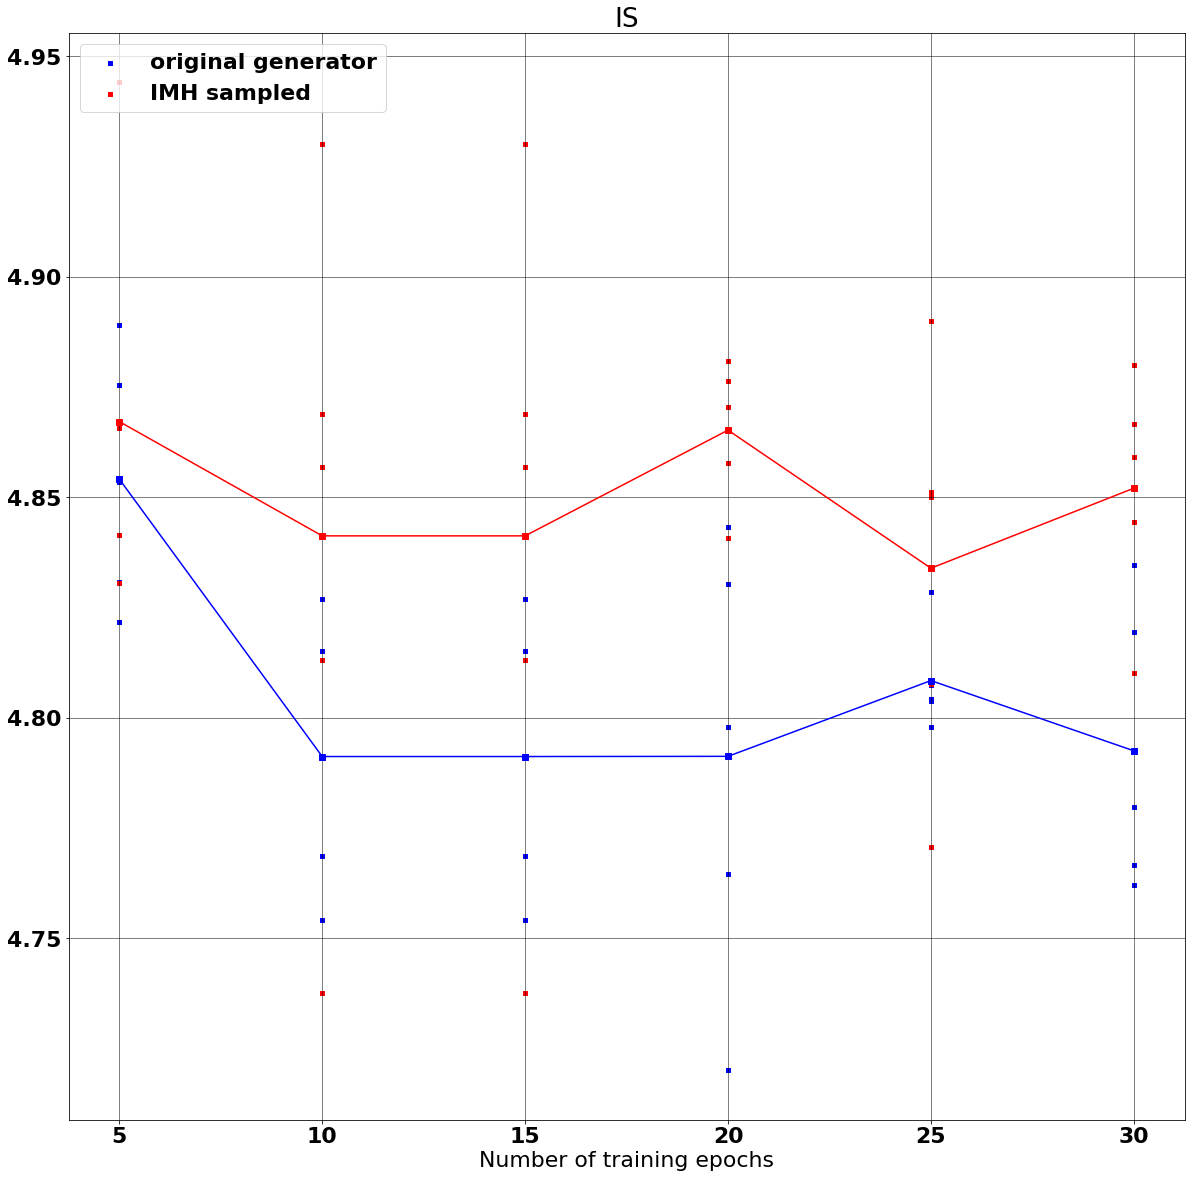

In [151]:
fig = plt.figure(figsize=(20,20))
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
ax1 = fig.add_subplot(111)
ax1.scatter( [5,10,15,20,25,30],g_is[:,0], s=10, c='b', marker="s", label='original generator')
ax1.scatter([5,10,15,20,25,30],g_is[:,1], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_is[:,2], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_is[:,3], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_is[:,4], s=10, c='b', marker="s")

ax1.scatter( [5,10,15,20,25,30],imh_is[:,0], s=10, c='r', marker="s", label='IMH sampled')
ax1.scatter( [5,10,15,20,25,30],imh_is[:,1], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_is[:,2], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_is[:,3], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_is[:,4], s=10, c='r', marker="s")

ax1.plot( [5,10,15,20,25,30],np.mean(imh_is[:],axis=1), c='r', marker="s")
ax1.plot( [5,10,15,20,25,30],np.mean(g_is[:],axis=1), c='b', marker="s")
ax1.grid(color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Number of training epochs')

plt.title('IS')
plt.legend(loc='upper left');
plt.savefig('IS_M')

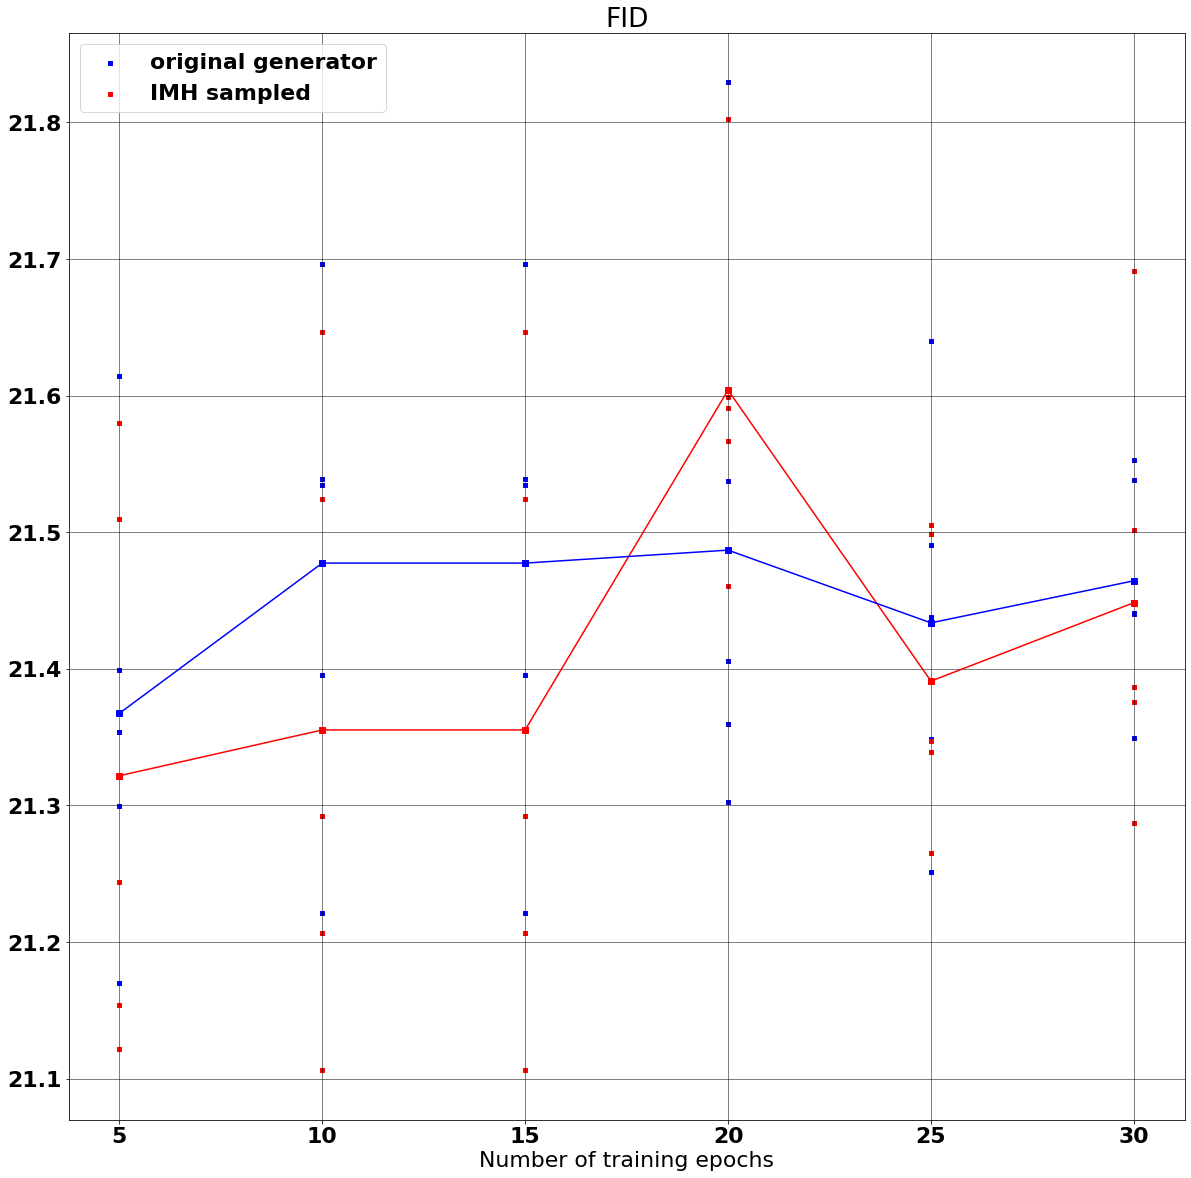

In [149]:
fig = plt.figure(figsize=(20,20))

font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
ax1 = fig.add_subplot(111)
ax1.scatter( [5,10,15,20,25,30],g_fid[:,0], s=10, c='b', marker="s", label='original generator')
ax1.scatter([5,10,15,20,25,30],g_fid[:,1], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_fid[:,2], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_fid[:,3], s=10, c='b', marker="s")
ax1.scatter([5,10,15,20,25,30],g_fid[:,4], s=10, c='b', marker="s")

ax1.scatter( [5,10,15,20,25,30],imh_fid[:,0], s=10, c='r', marker="s", label='IMH sampled')
ax1.scatter( [5,10,15,20,25,30],imh_fid[:,1], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_fid[:,2], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_fid[:,3], s=10, c='r', marker="s")
ax1.scatter( [5,10,15,20,25,30],imh_fid[:,4], s=10, c='r', marker="s")

ax1.plot( [5,10,15,20,25,30],np.mean(imh_fid[:],axis=1), c='r', marker="s")
ax1.plot( [5,10,15,20,25,30],np.mean(g_fid[:],axis=1), c='b', marker="s")
ax1.grid(color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Number of training epochs')

plt.title('FID')
plt.legend(loc='upper left');
plt.savefig('FID_M')